<a href="https://colab.research.google.com/github/Nigel-Anthony/Algorithmic-Decision-Making-in-Mortgage-Origination-A-Study-on-Racial-Bias/blob/main/ML_Finance_CA_PartC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Section C: Regression Modeling and Machine Learning Application on Option Chain Data


In [ ]:
import yfinance as yf
import pandas as pd
from datetime import datetime

# Function to simulate fetching Treasury bill rates
def get_treasury_rate_for_maturity(maturity_date):
    # Simulate: Replace this with actual fetching logic
    # This could be an API call or web scraping, depending on your data source
    # treasury rate as per Fed Funds. checked on the 30-5-2024.
    return 0.0533

# Replace 'NVDA' with the ticker you're interested in
ticker_symbol = 'NVDA'

# Fetch the data for the specified ticker symbol
ticker = yf.Ticker(ticker_symbol)
all_options = pd.DataFrame()

# Fetch all available expiration dates for options
expiration_dates = ticker.options

for date in expiration_dates:
    opt = ticker.option_chain(date)

    calls = opt.calls
    calls['Expiry'] = date
    calls['Type'] = 'Call'

    puts = opt.puts
    puts['Expiry'] = date
    puts['Type'] = 'Put'

    options = pd.concat([calls, puts])
    all_options = pd.concat([all_options, options])

# Add additional columns
all_options['Date'] = datetime.now().strftime('%Y-%m-%d')
all_options['Expiry'] = pd.to_datetime(all_options['Expiry'])
all_options['Days to Expiration'] = (all_options['Expiry'] - pd.to_datetime(all_options['Date'])).dt.days

# Fetch stock price and dividend yield (these values are constant for this snapshot)
stock_info = ticker.info
stock_price = stock_info['previousClose']
dividend_yield = stock_info['dividendYield'] if 'dividendYield' in stock_info else None

# Add stock price and dividend yield to each row
all_options['Stock Price'] = stock_price
all_options['Dividend Yield'] = dividend_yield if dividend_yield is not None else 0

# Add Treasury Bill Rate based on option maturity
all_options['Treasury Rate'] = all_options['Expiry'].apply(lambda x: get_treasury_rate_for_maturity(x))

# Export to CSV
csv_file_name = f'{ticker_symbol}_option_chain_data.csv'
all_options.to_csv(csv_file_name, index=False)

print(f'Option chain data for {ticker_symbol} has been written to {csv_file_name}')
df=all_options


Option chain data for NVDA has been written to NVDA_option_chain_data.csv


In [ ]:
df.shape

(7929, 21)

In [ ]:
# Step 2: Filter out 'Put' options
df_calls = df[df['Type'] == 'Call']

In [ ]:
df_calls.shape

(4114, 21)

In [ ]:
# Step 3: Remove rows with the first two expiry dates
expiry_dates = df_calls['Expiry'].unique()
expiry_dates_sorted = sorted(expiry_dates)
df_filtered = df_calls[~df_calls['Expiry'].isin(expiry_dates_sorted[:2])]

In [ ]:
df_filtered.shape

(3784, 21)

In [ ]:
# Step 4: Select specific columns
columns = ['strike', 'bid', 'ask', 'volume', 'openInterest', 'impliedVolatility', 'inTheMoney', 'Expiry', 'Type', 'Date', 'Days to Expiration', 'Stock Price']
df_final = df_filtered[columns]

In [ ]:
df_final.shape

(3784, 12)

In [ ]:
# Use the first (or any specific) stock price value
stock_price = df_final['Stock Price'].iloc[0]  # Assuming the stock price is consistent

# Calculate 30% above and below based on this stock price
lower_bound = stock_price * 0.7
upper_bound = stock_price * 1.3

# Filter the DataFrame
filtered_df = df_final[(df_final['strike'] >= lower_bound) & (df_final['strike'] <= upper_bound)]


In [ ]:
filtered_df.shape

(1288, 12)

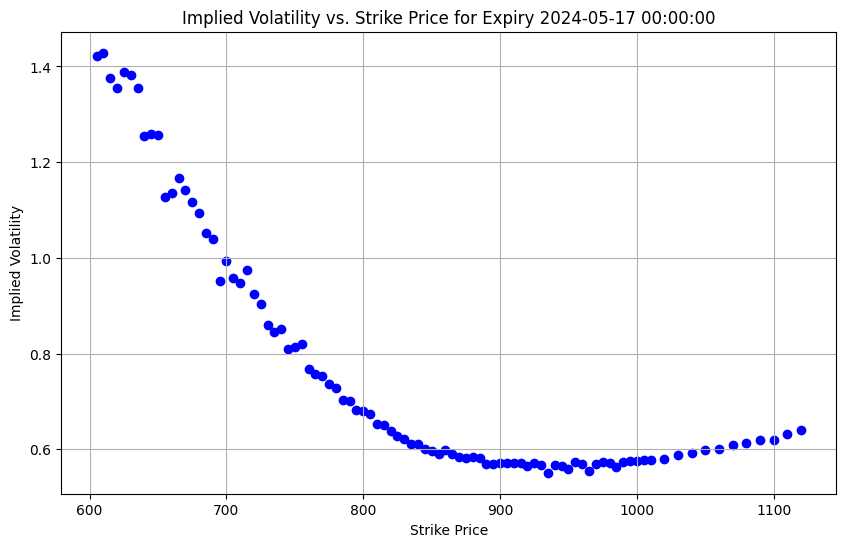

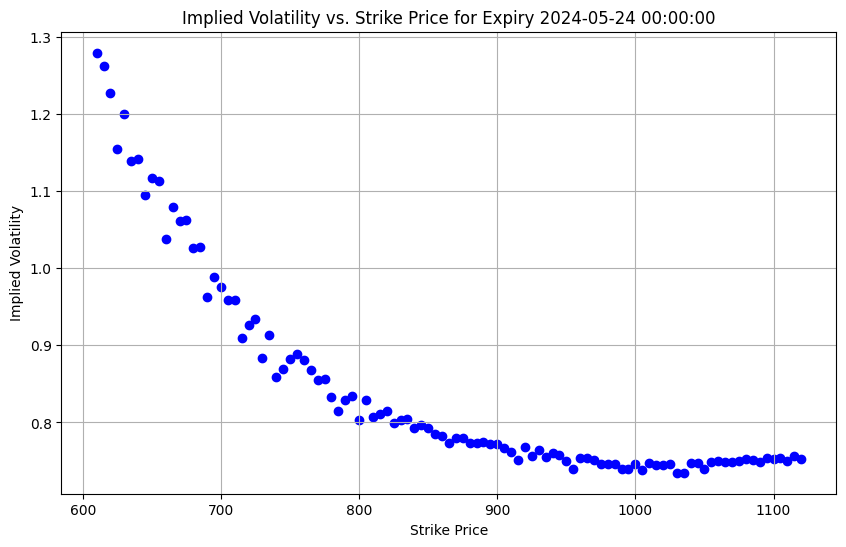

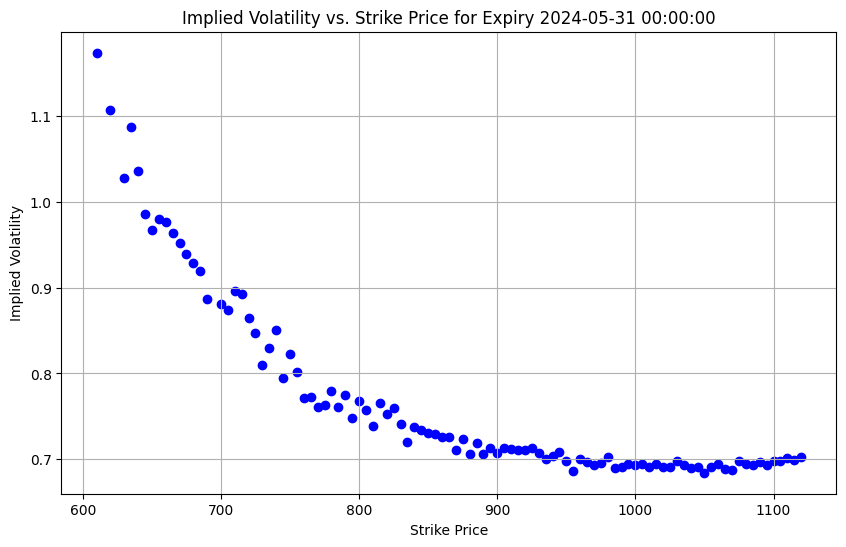

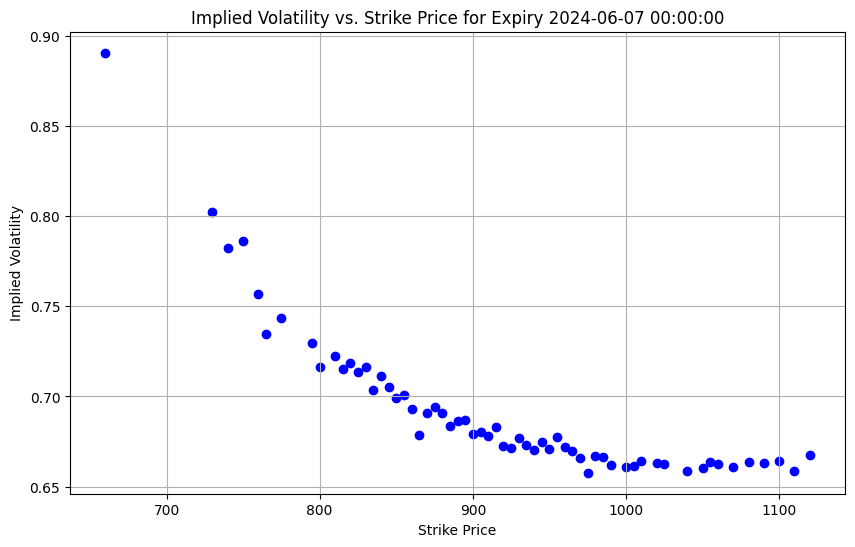

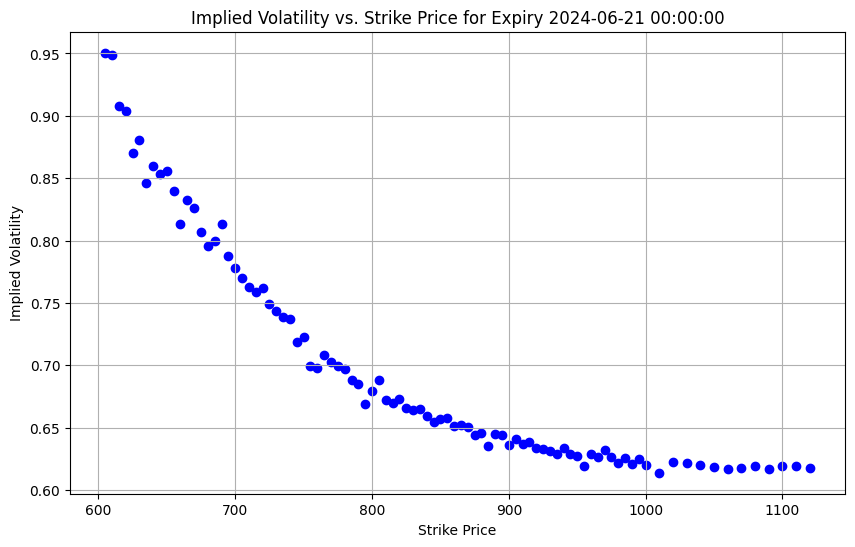

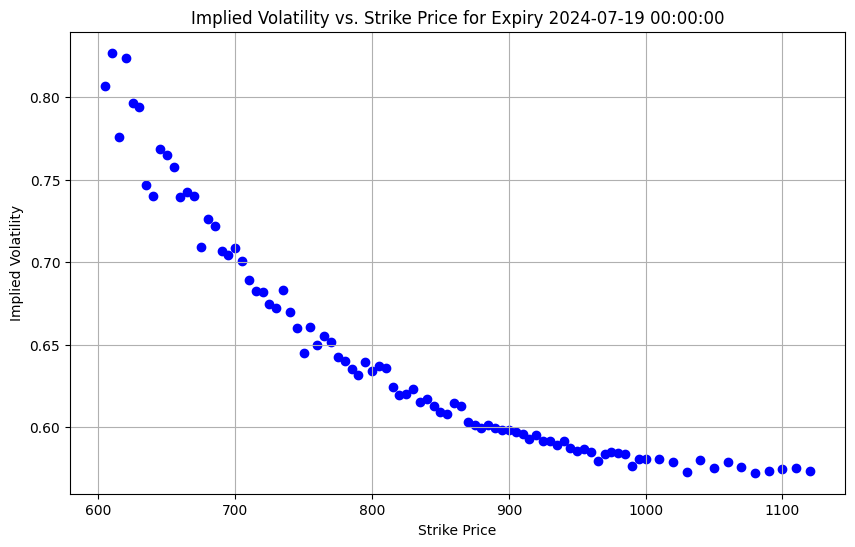

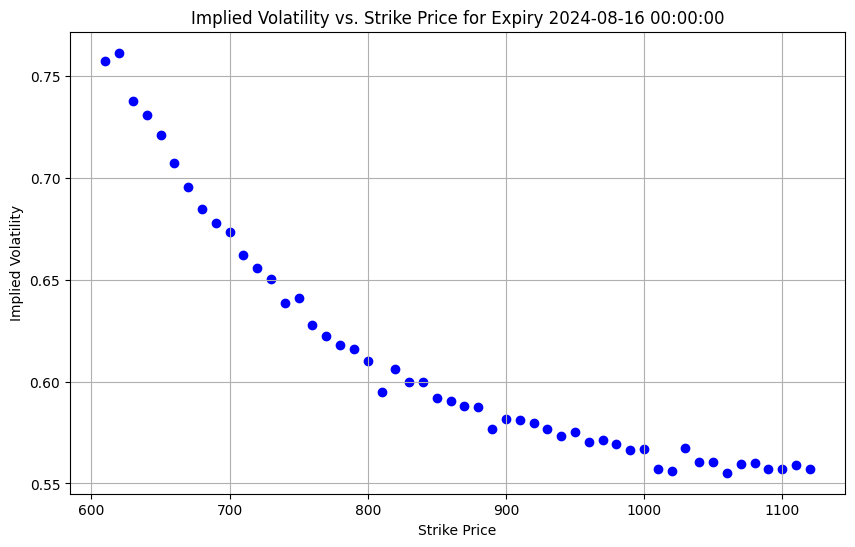

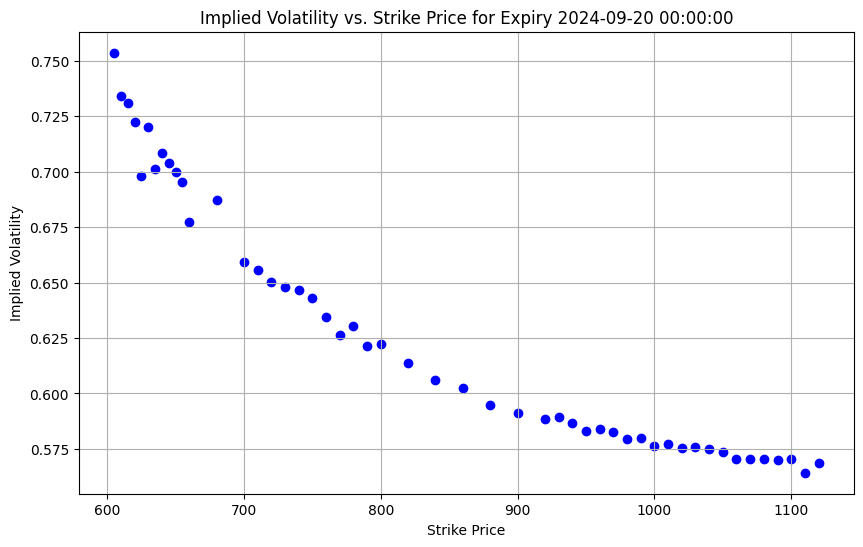

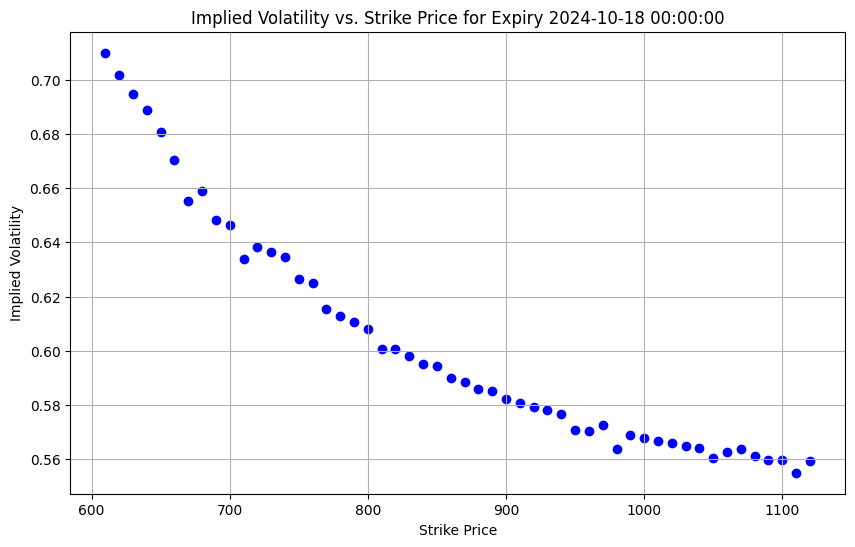

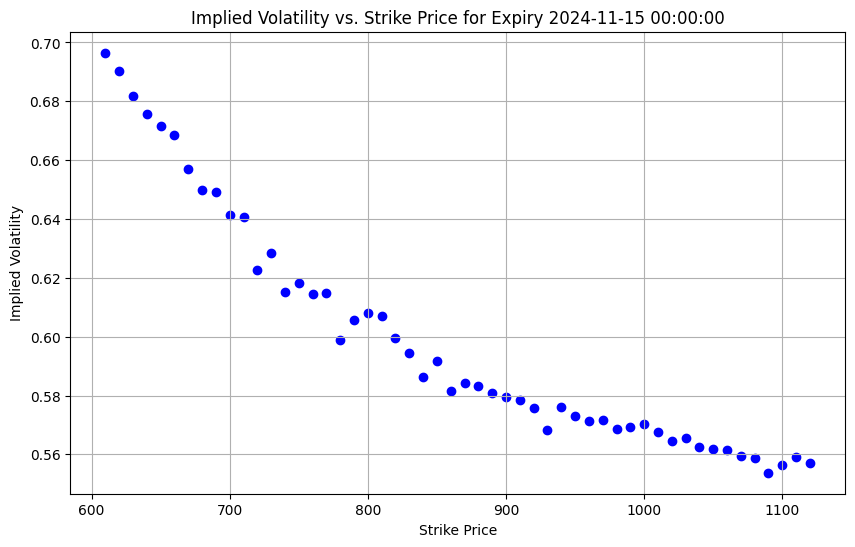

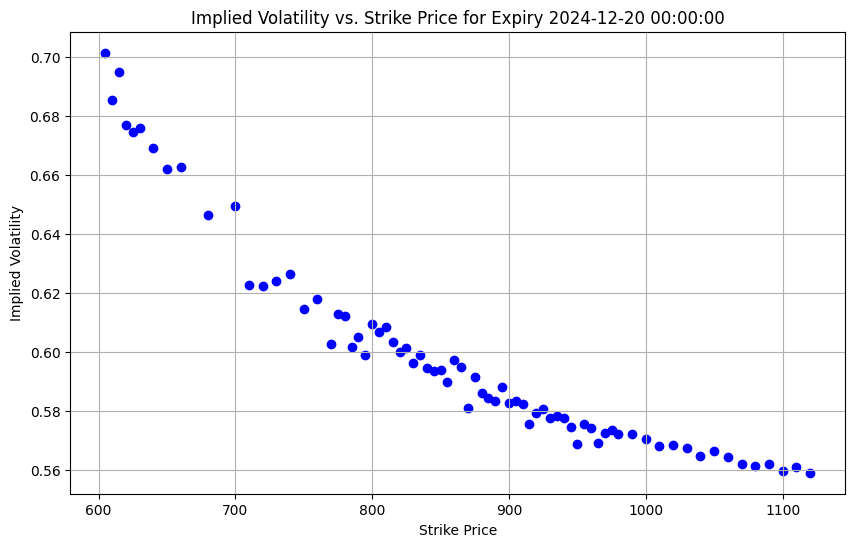

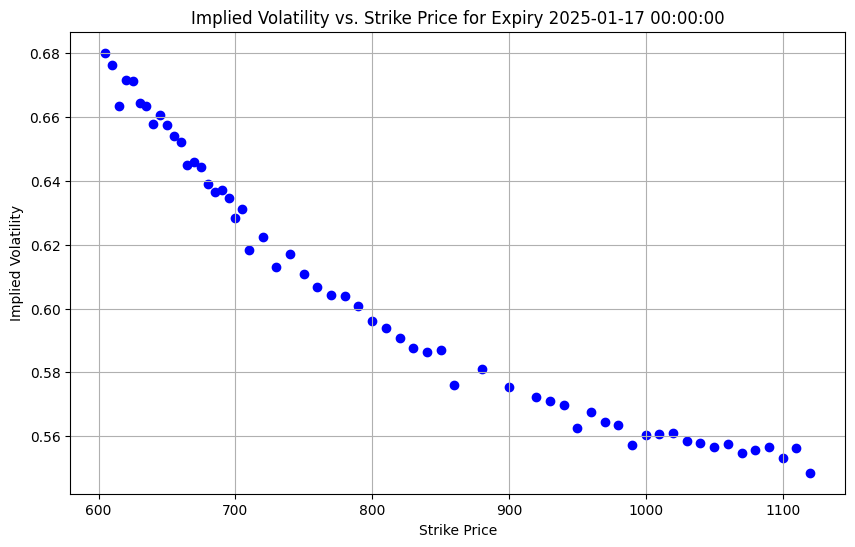

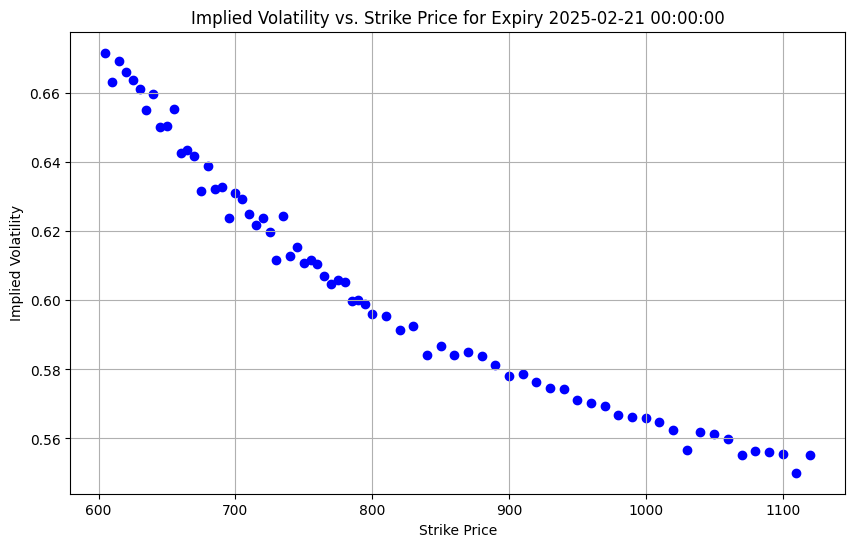

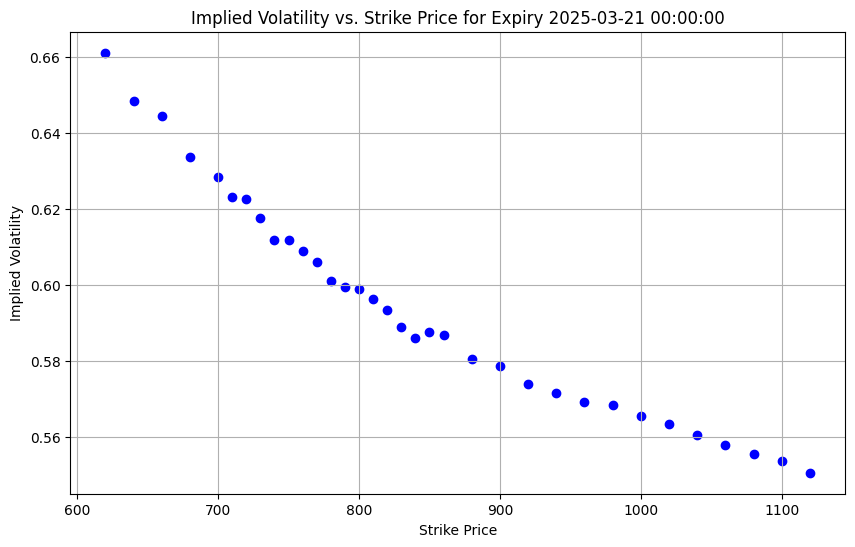

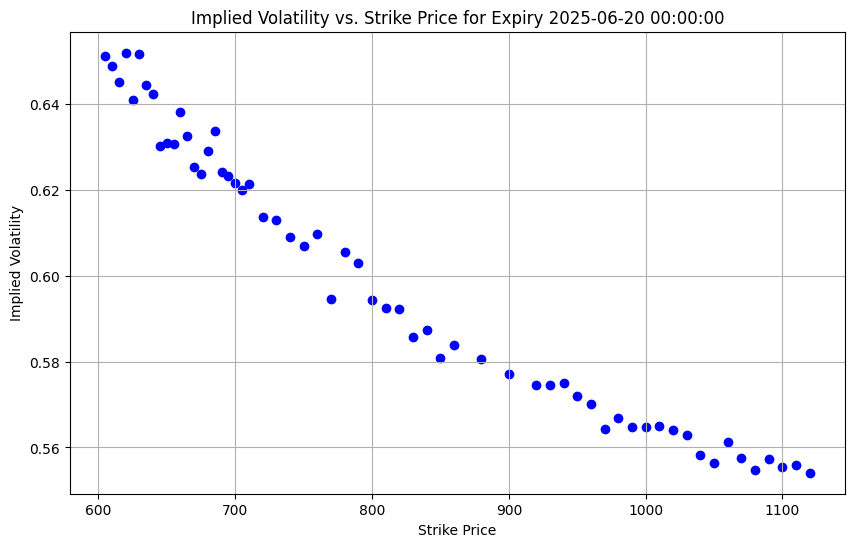

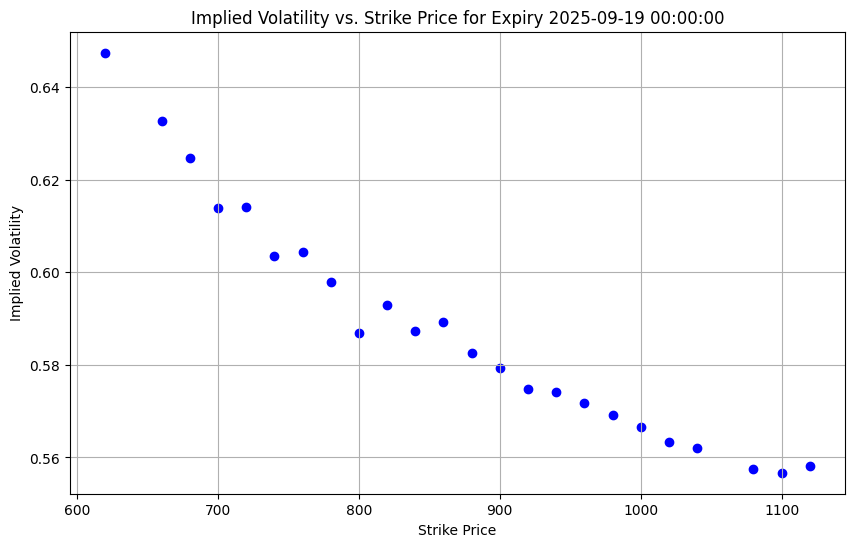

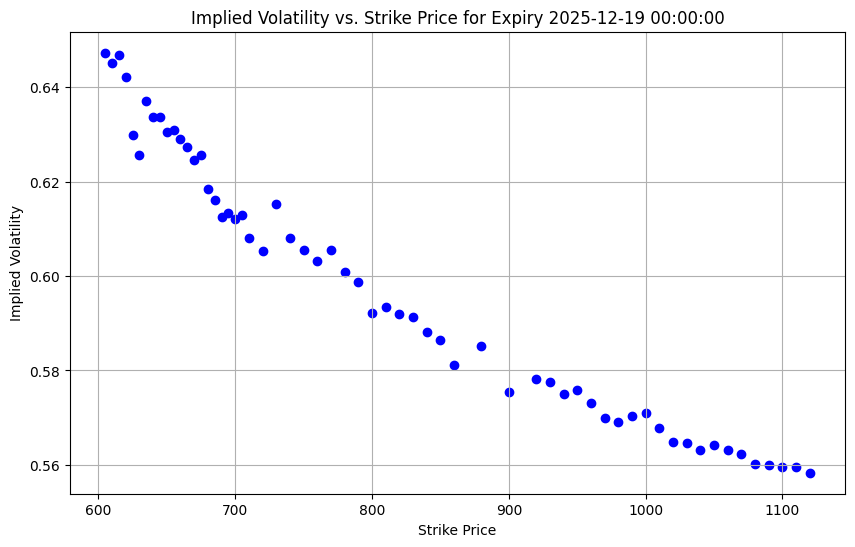

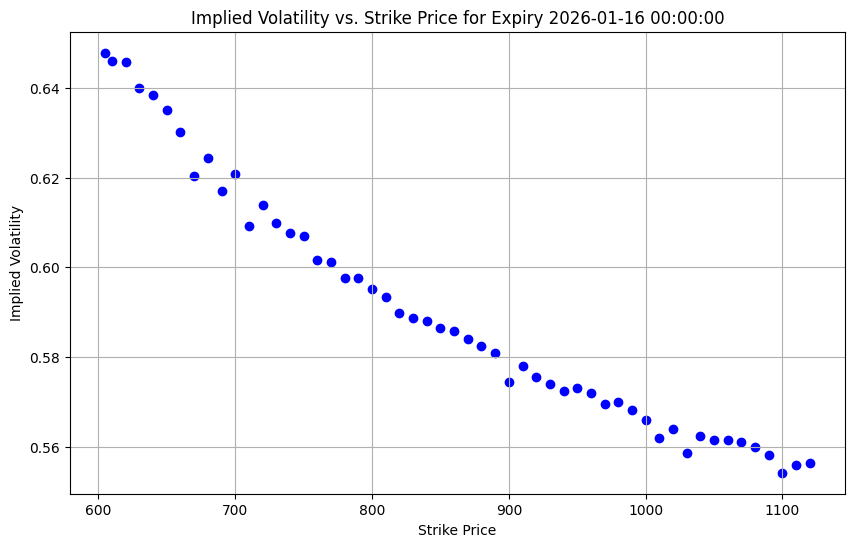

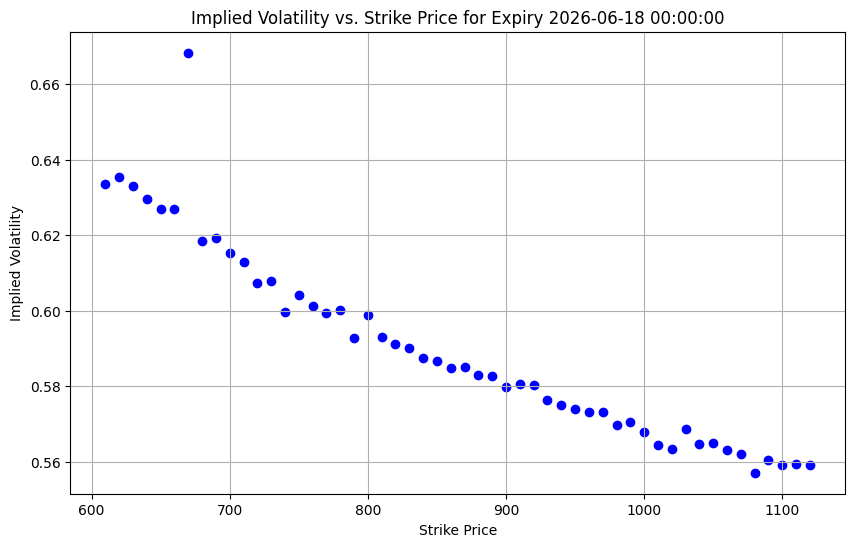

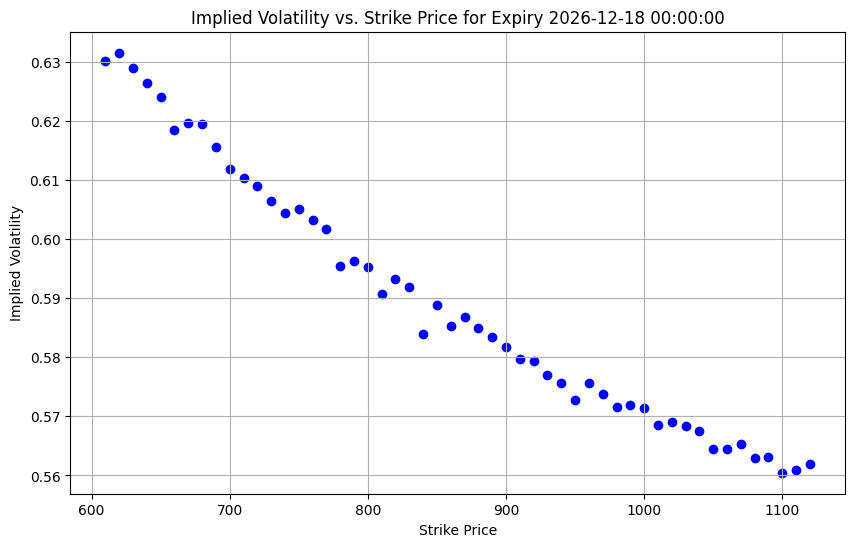

In [ ]:
import matplotlib.pyplot as plt

# Assuming filtered_df is your filtered DataFrame
# Ensure your DataFrame includes 'Expiry', 'impliedVolatility', and 'strike' columns

# Get unique expiry dates
unique_expiry_dates = filtered_df['Expiry'].unique()

# Loop through each expiry date to create separate graphs
for expiry_date in unique_expiry_dates:
    # Filter the DataFrame for the current expiry date
    df_expiry = filtered_df[filtered_df['Expiry'] == expiry_date]

    # Plot implied volatility vs. strike price
    plt.figure(figsize=(10, 6))  # Set the figure size (width, height) in inches
    plt.scatter(df_expiry['strike'], df_expiry['impliedVolatility'], marker='o', color='blue')

    # Set graph title and labels
    plt.title(f'Implied Volatility vs. Strike Price for Expiry {expiry_date}')
    plt.xlabel('Strike Price')
    plt.ylabel('Implied Volatility')

    # Show the plot
    plt.grid(True)  # Optional: Add grid for better readability
    plt.show()


In [ ]:
import numpy as np
from scipy.interpolate import griddata
import plotly.graph_objects as go

# Generating a structured grid
grid_x, grid_y = np.mgrid[min(df_calls['strike']):max(df_calls['strike']):100j,
                          min(df_calls['Days to Expiration']):max(df_calls['Days to Expiration']):100j]

# Interpolating data
grid_z = griddata((df_calls['strike'], df_calls['Days to Expiration']),
                  df_calls['impliedVolatility'],
                  (grid_x, grid_y), method='cubic')

# Plotting
fig = go.Figure(data=[go.Surface(z=grid_z, x=grid_x, y=grid_y)])
fig.update_layout(title='Volatility Surface: Implied Volatility vs. Strike Price vs. Days to Expiration - all call options',
                  scene=dict(xaxis_title='Strike Price',
                             yaxis_title='Days to Expiration',
                             zaxis_title='Implied Volatility'))
fig.show()


In [ ]:
import numpy as np
from scipy.interpolate import griddata
import plotly.graph_objects as go
import pandas as pd

# Assuming filtered_df is your original DataFrame

# Create a copy of the DataFrame to work with
df_copy = filtered_df.copy()

# Convert 'Expiry' to datetime if it's not already, and sort the copy

# Load data
# df_copy = pd.read_csv('calculated_iv.csv')

# Convert 'Expiry' column to datetime
df_copy['Expiry'] = pd.to_datetime(df_copy['Expiry'])

# Sort DataFrame by 'Expiry' in ascending order
df_copy.sort_values(by='Expiry', inplace=True)


# Assuming df_copy is your DataFrame
#df_copy['Expiry'] = pd.to_datetime(df_copy['Expiry'], format='%d/%m/%Y')
#df_copy.sort_values(by='Expiry', inplace=True)


# Get unique sorted expiry dates
unique_expiry_dates = df_copy['Expiry'].unique()

# Exclude the first 2 and the last 10 expiry dates
valid_expiry_dates = unique_expiry_dates[2:-10]

# Filter the DataFrame to include only the valid expiry dates
df_filtered = df_copy[df_copy['Expiry'].isin(valid_expiry_dates)]

# Now, proceed with preparing the data for the surface plot
# Generating a structured grid
grid_x, grid_y = np.mgrid[min(df_filtered['strike']):max(df_filtered['strike']):100j,
                          min(df_filtered['Days to Expiration']):max(df_filtered['Days to Expiration']):100j]

# Interpolating data
grid_z = griddata((df_filtered['strike'], df_filtered['Days to Expiration']),
                  df_filtered['impliedVolatility'],
                  (grid_x, grid_y), method='cubic')

# Plotting
fig = go.Figure(data=[go.Surface(z=grid_z, x=grid_x, y=grid_y)])
fig.update_layout(title='Filtered Volatility Surface: Implied Volatility vs. Strike Price vs. Days to Expiration',
                  scene=dict(xaxis_title='Strike Price',
                             yaxis_title='Days to Expiration',
                             zaxis_title='Implied Volatility'))
fig.show()



EDA

In [ ]:
df_filtered.columns


Index(['contractSymbol', 'lastTradeDate', 'strike', 'lastPrice', 'bid', 'ask',
       'change', 'percentChange', 'volume', 'openInterest',
       'impliedVolatility', 'inTheMoney', 'contractSize', 'currency', 'Expiry',
       'Type', 'Date', 'Days to Expiration', 'Stock Price', 'Dividend Yield',
       'Treasury Rate'],
      dtype='object')

In [ ]:
import pandas as pd

# Assuming df is your original DataFrame
# Define the specific columns you want to include in the new DataFrame
columns_to_include = ['strike', 'lastPrice', 'bid', 'ask', 'change', 'percentChange', 'volume', 'openInterest',
       'impliedVolatility', 'Stock Price', 'Dividend Yield',
       'Treasury Rate']

# Create a new DataFrame with specific columns
df_eda = df_filtered[columns_to_include].copy()

df_eda.shape




(3784, 12)

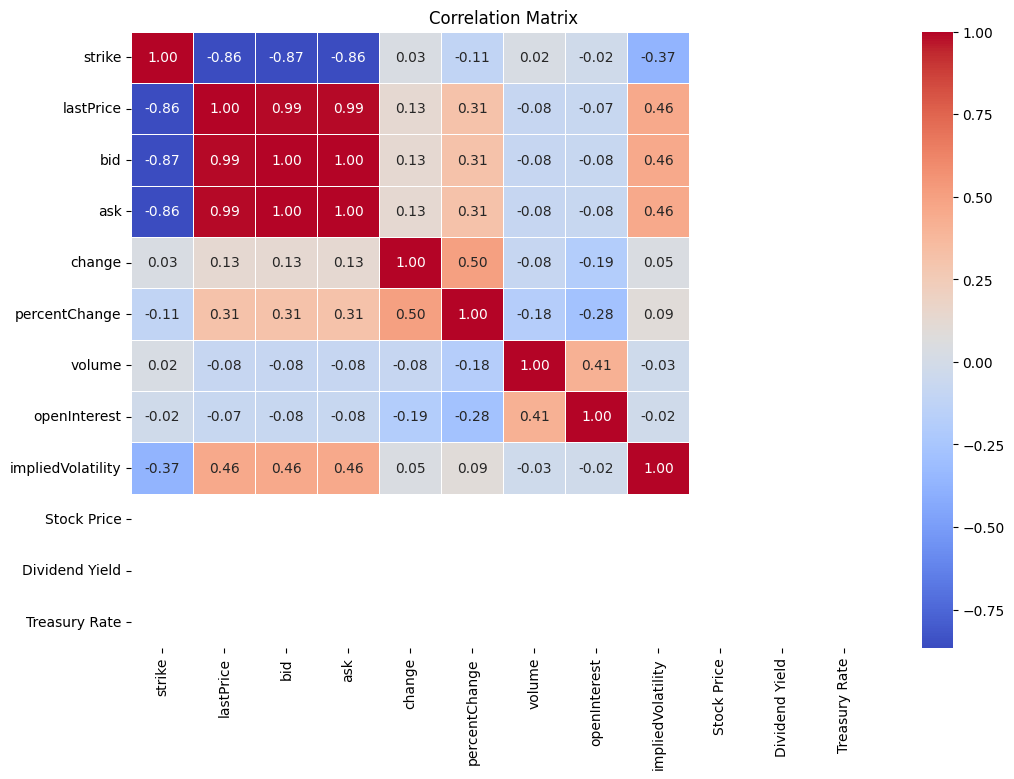

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

corr = df_eda.corr()

# Plot correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

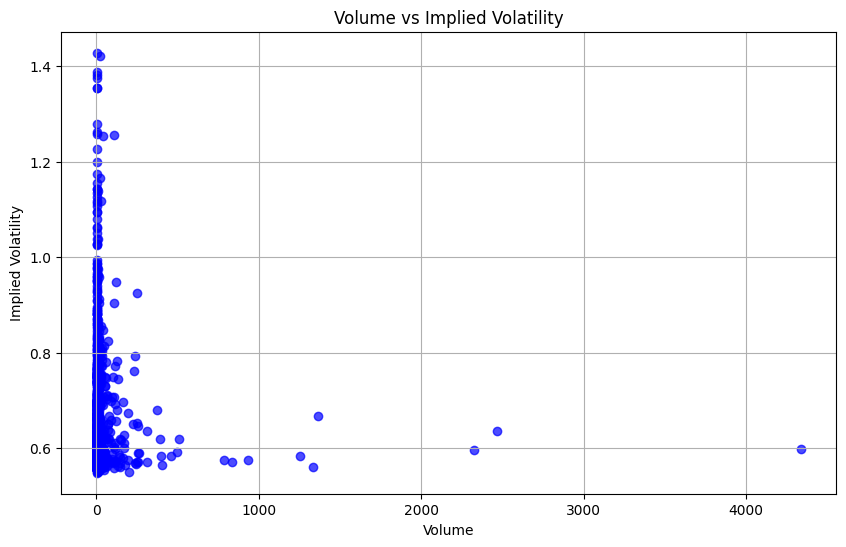

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame containing the dataset
# If not, replace df with your DataFrame name

# Plot scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(filtered_df['volume'], filtered_df['impliedVolatility'], color='blue', alpha=0.7)
plt.title('Volume vs Implied Volatility')
plt.xlabel('Volume')
plt.ylabel('Implied Volatility')
plt.grid(True)
plt.show()


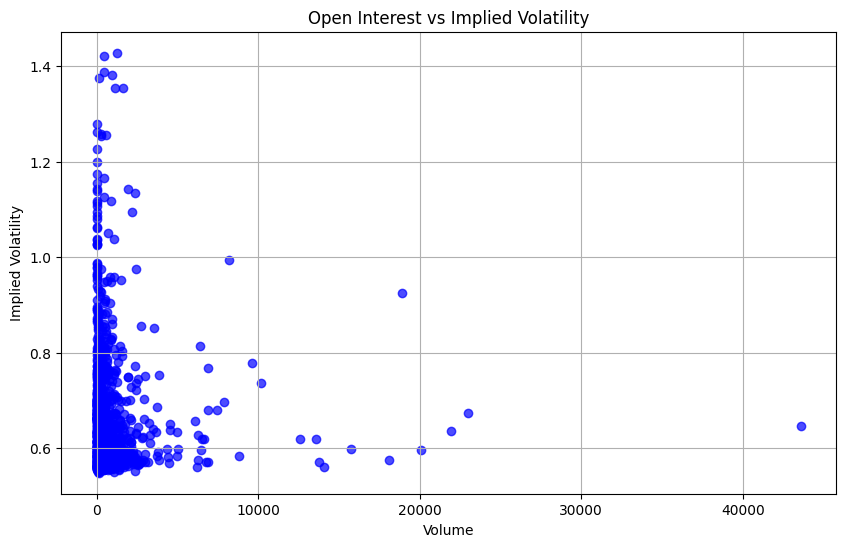

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame containing the dataset
# If not, replace df with your DataFrame name

# Plot scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(filtered_df['openInterest'], filtered_df['impliedVolatility'], color='blue', alpha=0.7)
plt.title('Open Interest vs Implied Volatility')
plt.xlabel('Volume')
plt.ylabel('Implied Volatility')
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd

# Assuming filtered_df is your DataFrame that includes 'strike' and 'Days to Expiration'

# Create a copy of the DataFrame to work with, to preserve the original data
df_modeling = filtered_df.copy()

# Create the 'K' column from 'strike'
df_modeling['K'] = df_modeling['strike']

# Create the 'T' column from 'Days to Expiration', converting days to years
df_modeling['T'] = df_modeling['Days to Expiration'] / 365

# Create 'T squared' and 'K squared' columns
df_modeling['T squared'] = df_modeling['T'] ** 2
df_modeling['K squared'] = df_modeling['K'] ** 2

# Create the 'K*T' column
df_modeling['K*T'] = df_modeling['K'] * df_modeling['T']

# Display the first few rows of the modified DataFrame to verify the new columns
df_modeling

strike     bid     ask  volume  openInterest  impliedVolatility  \
108   605.0  241.70  245.85    20.0           482           1.421268   
109   610.0  237.90  242.10     2.0          1296           1.428592   
110   615.0  231.80  236.35     2.0           183           1.376468   
111   620.0  227.15  231.30     3.0          1158           1.354129   
112   625.0  224.55  228.50     5.0           433           1.388065   
..      ...     ...     ...     ...           ...                ...   
107  1080.0  223.65  227.30     4.0           127           0.562955   
108  1090.0  221.45  225.20     5.0            12           0.563187   
109  1100.0  217.90  221.35    50.0          1168           0.560456   
110  1110.0  215.60  219.75     3.0            53           0.560952   
111  1120.0  214.30  217.75     5.0           191           0.561959   

     inTheMoney     Expiry  Type        Date  Days to Expiration  Stock Price  \
108        True 2024-05-17  Call  2024-05-01                  16       864.02   
109        True 2024-05-17  Call  2024-05-01                  16       864.02   
110        True 2024-05-17  Call  2024-05-01                  16       864.02   
111        True 2024-05-17  Call  2024-05-01                  16       864.02   
112        True 2024-05-17  Call  2024-05-01                  16       864.02   
..          ...        ...   ...         ...                 ...          ...   
107       False 2026-12-18  Call  2024-05-01                 961       864.02   
108       False 2026-12-18  Call  2024-05-01                 961       864.02   
109       False 2026-12-18  Call  2024-05-01                 961       864.02   
110       False 2026-12-18  Call  2024-05-01                 961       864.02   
111       False 2026-12-18  Call  2024-05-01                 961       864.02   

          K         T  T squared  K squared          K*T  
108   605.0  0.043836   0.001922   366025.0    26.520548  
109   610.0  0.043836   0.001922   372100.0    26.739726  
110   615.0  0.043836   0.001922   378225.0    26.958904  
111   620.0  0.043836   0.001922   384400.0    27.178082  
112   625.0  0.043836   0.001922   390625.0    27.397260  
..      ...       ...        ...        ...          ...  
107  1080.0  2.632877   6.932040  1166400.0  2843.506849  
108  1090.0  2.632877   6.932040  1188100.0  2869.835616  
109  1100.0  2.632877   6.932040  1210000.0  2896.164384  
110  1110.0  2.632877   6.932040  1232100.0  2922.493151  
111  1120.0  2.632877   6.932040  1254400.0  2948.821918  

[1288 rows x 17 columns]

In [ ]:
# Assuming 'df_modeling'  includes 'impliedVolatility'

# Features and target variable
X = df_modeling[['K', 'K squared', 'T', 'T squared', 'K*T']]
y = df_modeling['impliedVolatility']


In [ ]:
# Optionally, save the filtered data to a new CSV file
df_modeling.to_csv('df_modeling.csv', index=False)

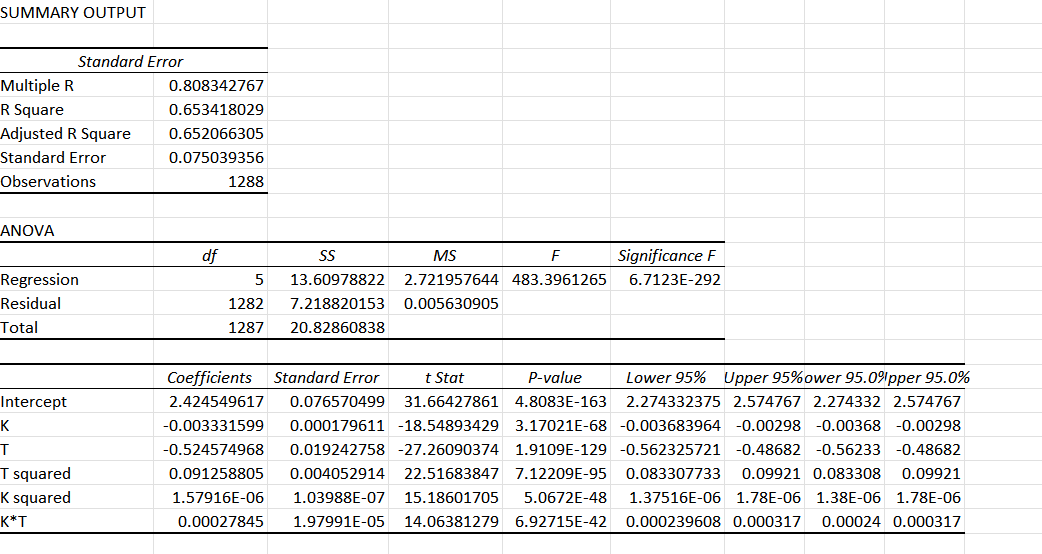

In [ ]:
import statsmodels.api as sm

# Adding a constant for the intercept term
X_sm = sm.add_constant(X)
model_ols = sm.OLS(y, X_sm).fit()
print(model_ols.summary())

                            OLS Regression Results                            
Dep. Variable:      impliedVolatility   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     483.4
Date:                Wed, 01 May 2024   Prob (F-statistic):          6.71e-292
Time:                        14:28:36   Log-Likelihood:                 1511.0
No. Observations:                1288   AIC:                            -3010.
Df Residuals:                    1282   BIC:                            -2979.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4245      0.077     31.664      0.0

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
import statsmodels.api as sm

# Adding a constant for the intercept term
X_train_sm = sm.add_constant(X_train)
model_ols = sm.OLS(y_train, X_train_sm).fit()
print(model_ols.summary())


                            OLS Regression Results                            
Dep. Variable:      impliedVolatility   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     385.2
Date:                Wed, 01 May 2024   Prob (F-statistic):          2.45e-232
Time:                        14:40:18   Log-Likelihood:                 1176.5
No. Observations:                1030   AIC:                            -2341.
Df Residuals:                    1024   BIC:                            -2311.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4625      0.088     28.069      0.0

In [ ]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Initialize the models
models = {
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'RandomForest': RandomForestRegressor()
}

# Train the models and evaluate
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    # Calculate metrics
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, predictions)

    print(f"{name} - R2: {r2:.4f}, MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")


Ridge - R2: 0.6574, MSE: 0.0042, MAE: 0.0503, RMSE: 0.0645
Lasso - R2: 0.3813, MSE: 0.0075, MAE: 0.0669, RMSE: 0.0867
ElasticNet - R2: 0.3810, MSE: 0.0075, MAE: 0.0669, RMSE: 0.0867
RandomForest - R2: 0.9883, MSE: 0.0001, MAE: 0.0062, RMSE: 0.0119


In [ ]:
import numpy as np
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler

# Create the grid for K and T as before
K_values = np.linspace(X['K'].min(), X['K'].max(), 100)
T_values = np.linspace(X['T'].min(), X['T'].max(), 100)
K_grid, T_grid = np.meshgrid(K_values, T_values)

# Flatten the grid to use for predictions
X_grid = pd.DataFrame({
    'K': K_grid.ravel(),
    'K squared': (K_grid**2).ravel(),
    'T': T_grid.ravel(),
    'T squared': (T_grid**2).ravel(),
    'K*T': (K_grid * T_grid).ravel()
})

# Standardize features if required by the models
scaler = StandardScaler().fit(X_train)
X_grid_scaled = scaler.transform(X_grid)  # Only scale if your models were trained on scaled data

# Iterate through each model, generate predictions, and create a plot
for name, model in models.items():
    # Determine if the model requires scaled data
    predictions = model.predict(X_grid_scaled if name in ['Ridge', 'Lasso', 'ElasticNet'] else X_grid)
    predictions = predictions.reshape(K_grid.shape)

    # Create a 3D surface plot for each model
    fig = go.Figure(data=[go.Surface(x=K_grid, y=T_grid, z=predictions)])

    # Update the plot layout
    fig.update_layout(
        title=f'{name} Implied Volatility Surface',
        scene=dict(
            xaxis_title='Strike Price (K)',
            yaxis_title='Time to Maturity (T)',
            zaxis_title='Implied Volatility'
        ),
        autosize=False,
        width=800,
        height=800
    )

    # Show the plot
    fig.show()



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but Ridge was fitted with feature names



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but Lasso was fitted with feature names



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but ElasticNet was fitted with feature names



In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import r2_score

# Normalize data for neural network
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the model
model_nn = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1)
])

model_nn.compile(optimizer=Adam(), loss='mse', metrics=['mae', 'mse'])

# Train the model
history = model_nn.fit(X_train_scaled, y_train, validation_split=0.2, epochs=100, batch_size=10, verbose=0)

# Evaluate the model
loss, mae, mse = model_nn.evaluate(X_test_scaled, y_test, verbose=0)
rmse = np.sqrt(mse)

# Predict on test data
y_pred = model_nn.predict(X_test_scaled)

# Calculate R-squared
r_squared = r2_score(y_test, y_pred)

print(f"Neural Network - MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}, R-squared: {r_squared:.4f}")


9/9 [==============================] - 0s 2ms/step
Neural Network - MSE: 0.0015, MAE: 0.0249, RMSE: 0.0389, R-squared: 0.8757


In [ ]:
# Adjusting Model Architecture
model_nn = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),  # Adding an additional layer
    Dense(1)
])

# Hyperparameter Tuning
model_nn.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae', 'mse'])

# Data Preprocessing
# Experiment with different preprocessing techniques or feature engineering methods.

# Early Stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model_nn.fit(X_train_scaled, y_train, validation_split=0.2, epochs=100, batch_size=10, verbose=0, callbacks=[early_stopping])

# Evaluate the model
loss, mae, mse = model_nn.evaluate(X_test_scaled, y_test, verbose=0)
rmse = np.sqrt(mse)

# Predict on test data
y_pred = model_nn.predict(X_test_scaled)

# Calculate R-squared
r_squared = r2_score(y_test, y_pred)

print(f"Neural Network - MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}, R-squared: {r_squared:.4f}")


9/9 [==============================] - 0s 2ms/step
Neural Network - MSE: 0.0013, MAE: 0.0204, RMSE: 0.0361, R-squared: 0.8924


LSTMs (Long Short-Term Memory networks)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

# Normalize data for LSTM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape the data for LSTM
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Define the model
model_lstm = Sequential([
    LSTM(64, activation='relu', input_shape=(1, X_train_scaled.shape[1]), return_sequences=True),
    LSTM(64, activation='relu'),
    Dense(1)
])

model_lstm.compile(optimizer=Adam(), loss='mse', metrics=['mae', 'mse'])

# Train the model
history = model_lstm.fit(X_train_reshaped, y_train, validation_split=0.2, epochs=100, batch_size=10, verbose=0)

# Evaluate the model
loss, mae, mse = model_lstm.evaluate(X_test_reshaped, y_test, verbose=0)
rmse = np.sqrt(mse)

# Predict on test data
y_pred = model_lstm.predict(X_test_reshaped)

# Calculate R-squared
r_squared = r2_score(y_test, y_pred)

print(f"LSTM - MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}, R-squared: {r_squared:.4f}")


9/9 [==============================] - 0s 2ms/step
LSTM - MSE: 0.0015, MAE: 0.0242, RMSE: 0.0393, R-squared: 0.8728


In [ ]:
import plotly.graph_objs as go
import plotly.express as px

# Predictions for training and test data
y_train_pred = model_lstm.predict(X_train_reshaped).flatten()
y_test_pred = model_lstm.predict(X_test_reshaped).flatten()

# Create a DataFrame for training data
train_data = pd.DataFrame({'Actual': y_train, 'Predicted': y_train_pred, 'Data': 'Training'})

# Create a DataFrame for test data
test_data = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred, 'Data': 'Test'})

# Concatenate training and test data
all_data = pd.concat([train_data, test_data], ignore_index=True)

# Plot the actual versus predicted values for training and test data
fig = px.scatter(all_data, x='Actual', y='Predicted', color='Data',
                 labels={'Actual': 'Actual Value', 'Predicted': 'Predicted Value'},
                 title='LSTM Model Performance on Training and Test Data')

# Add diagonal line for perfect predictions
fig.add_trace(go.Scatter(x=all_data['Actual'], y=all_data['Actual'], mode='lines', name='Perfect Prediction', line=dict(color='black', dash='dash')))

# Show the plot
fig.show()


9/9 [==============================] - 0s 4ms/step


GRUs (Gated Recurrent Units)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

# Normalize data for GRU
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape data for GRU input (samples, time steps, features)
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Define the GRU model
model_gru = Sequential([
    GRU(64, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)
])

model_gru.compile(optimizer=Adam(), loss='mse', metrics=['mae', 'mse'])

# Train the model
history = model_gru.fit(X_train_reshaped, y_train, validation_split=0.2, epochs=100, batch_size=10, verbose=0)

# Evaluate the model
loss, mae, mse = model_gru.evaluate(X_test_reshaped, y_test, verbose=0)
rmse = np.sqrt(mse)

# Predict on test data
y_pred = model_gru.predict(X_test_reshaped)

# Calculate R-squared
r_squared = r2_score(y_test, y_pred)

print(f"GRU - MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}, R-squared: {r_squared:.4f}")


9/9 [==============================] - 0s 2ms/step
GRU - MSE: 0.0014, MAE: 0.0235, RMSE: 0.0370, R-squared: 0.8873


In [ ]:
import plotly.graph_objs as go
import plotly.express as px

# Predictions for training and test data
y_train_pred = model_gru.predict(X_train_reshaped).flatten()
y_test_pred = model_gru.predict(X_test_reshaped).flatten()

# Create a DataFrame for training data
train_data = pd.DataFrame({'Actual': y_train, 'Predicted': y_train_pred, 'Data': 'Training'})

# Create a DataFrame for test data
test_data = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred, 'Data': 'Test'})

# Concatenate training and test data
all_data = pd.concat([train_data, test_data], ignore_index=True)

# Plot the actual versus predicted values for training and test data
fig = px.scatter(all_data, x='Actual', y='Predicted', color='Data',
                 labels={'Actual': 'Actual Value', 'Predicted': 'Predicted Value'},
                 title='GRU Model Performance on Training and Test Data')

# Add diagonal line for perfect predictions
fig.add_trace(go.Scatter(x=all_data['Actual'], y=all_data['Actual'], mode='lines', name='Perfect Prediction', line=dict(color='black', dash='dash')))

# Show the plot
fig.show()


9/9 [==============================] - 0s 4ms/step


Bidirectional LSTMS

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

# Normalize data for neural network
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the model
model_bidirectional = Sequential([
    Bidirectional(LSTM(64, activation='relu', return_sequences=True), input_shape=(X_train_scaled.shape[1], 1)),
    Bidirectional(LSTM(64, activation='relu', return_sequences=True)),
    Bidirectional(LSTM(64, activation='relu')),
    Dense(1)
])

model_bidirectional.compile(optimizer=Adam(), loss='mse', metrics=['mae', 'mse'])

# Reshape input data for LSTM (add an additional dimension)
X_train_rnn = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_rnn = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

# Train the model
history = model_bidirectional.fit(X_train_rnn, y_train, validation_split=0.2, epochs=100, batch_size=10, verbose=0)

# Evaluate the model
loss, mae, mse = model_bidirectional.evaluate(X_test_rnn, y_test, verbose=0)
rmse = np.sqrt(mse)

# Predict on test data
y_pred = model_bidirectional.predict(X_test_rnn)

# Calculate R-squared
r_squared = r2_score(y_test, y_pred)

print(f"Bidirectional LSTM - MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}, R-squared: {r_squared:.4f}")


9/9 [==============================] - 1s 6ms/step
Bidirectional LSTM - MSE: 0.0016, MAE: 0.0221, RMSE: 0.0406, R-squared: 0.8644


Bidirectional GRUs

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Bidirectional
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

# Normalize data for GRU
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape data for GRU input (samples, time steps, features)
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Define the bidirectional GRU model
model_bidirectional_gru = Sequential([
    Bidirectional(GRU(64, activation='relu'), input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
    Dense(64, activation='relu'),
    Dense(1)
])

model_bidirectional_gru.compile(optimizer=Adam(), loss='mse', metrics=['mae', 'mse'])

# Train the model
history = model_bidirectional_gru.fit(X_train_reshaped, y_train, validation_split=0.2, epochs=100, batch_size=10, verbose=0)

# Evaluate the model
loss, mae, mse = model_bidirectional_gru.evaluate(X_test_reshaped, y_test, verbose=0)
rmse = np.sqrt(mse)

# Predict on test data
y_pred = model_bidirectional_gru.predict(X_test_reshaped)

# Calculate R-squared
r_squared = r2_score(y_test, y_pred)

print(f"Bidirectional GRU - MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}, R-squared: {r_squared:.4f}")


9/9 [==============================] - 0s 2ms/step
Bidirectional GRU - MSE: 0.0025, MAE: 0.0300, RMSE: 0.0502, R-squared: 0.7927


In [ ]:
import plotly.graph_objs as go

# Data
models = ['Ridge', 'Lasso', 'ElasticNet', 'RandomForest', 'Neural Network', 'Neural Network (Adjusted)', 'LSTM', 'GRU', 'Bidirectional LSTM', 'Bidirectional GRU']
r_squared = [0.6574, 0.3813, 0.3810, 0.9883, 0.8757, 0.8924, 0.8728, 0.8873, 0.8644, 0.7927]
mse = [0.0042, 0.0075, 0.0075, 0.0001, 0.0015, 0.0013, 0.0015, 0.0014, 0.0016, 0.0025]
mae = [0.0503, 0.0669, 0.0669, 0.0062, 0.0249, 0.0204, 0.0242, 0.0235, 0.0221, 0.0300]
rmse = [0.0645, 0.0867, 0.0867, 0.0119, 0.0389, 0.0361, 0.0393, 0.0370, 0.0406, 0.0502]

# Create traces
trace_r_squared = go.Bar(x=models, y=r_squared, name='R-squared')
trace_mse = go.Bar(x=models, y=mse, name='MSE')
trace_mae = go.Bar(x=models, y=mae, name='MAE')
trace_rmse = go.Bar(x=models, y=rmse, name='RMSE')

# Create subplots
fig = go.Figure(data=[trace_r_squared, trace_mse, trace_mae, trace_rmse])
fig.update_layout(barmode='group', title='Model Performance Metrics', xaxis_title='Model', yaxis_title='Value')

# Show plot
fig.show()




---



Because of its tolerance to outliers, capacity to handle non-linear
correlations, and ability to capture feature interactions, Random Forest performs better than Ridge, Lasso, and Elastic Net regression. In contrast to linear models, Random Forest uses ensemble learning to mitigate the impact of individual outliers by modeling complicated data patterns without the need for explicit feature engineering. By recognizing and integrating feature interactions automatically, it improves prediction accuracy. Additionally, Random Forest can withstand multicollinearity, which can cause linear regression models to become unstable. Its ensemble method efficiently controls the complexity of the model, avoiding overfitting and capturing complex decision limits. Random Forest is also less sensitive to regression assumption violations, which makes it appropriate for heteroscedastic or non-normal residual datasets. All things considered, these benefits make Random Forest a better option for regression tasks, especially when handling intricate, non-linear correlations in the data.

---






---

Because of its more straightforward architecture and fewer parameters, GRU (Gated Recurrent Unit) frequently performs better than LSTM (Long Short-Term Memory). This can result in improved generalization and a lower chance of overfitting, particularly in situations with less training data. By combining the input and forget gates of an LSTM into a single update gate, GRU improves computational efficiency and facilitates the efficient collection of long-range relationships. In addition, GRU features a reset gate that regulates information flow and helps shield deep recurrent networks from the vanishing gradient issue. Because of this characteristic, GRU is ideally suited for time series data such as implied volatility prediction in call options. It can also better capture temporal dependencies and preserve important information across longer sequences. Furthermore, GRU's more straightforward architecture facilitates training and interpretation, which in some circumstances might result in quicker convergence and improved performance. GRU outperforms LSTM in a variety of applications due to its overall efficiency, effectiveness in capturing long-range relationships, and simplicity.


---




**Additional Analysis**

Increasing the epoch value from 100 to 500 has proven to increase the LSTM and GRU model performances.

An epoch in LSTM and GRU neural networks is one iteration in which the training dataset is sent through the network both forward and backward to update the weights according to the calculated error. A greater number of epochs has various benefits. First of all, it makes training better by giving the model more opportunities to interact with the training data, which promotes greater convergence and increased accuracy over time. Furthermore, as the model is exposed to more complex patterns and relationships in the data, a larger number of epochs may aid in improved generalization. Moreover, longer epochs could help achieve convergence to the best solution—especially for intricate datasets or architectures.


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

# Normalize data for LSTM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape the data for LSTM
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Define the model
model_lstm_adjusted = Sequential([
    LSTM(64, activation='relu', input_shape=(1, X_train_scaled.shape[1]), return_sequences=True),
    LSTM(64, activation='relu'),
    Dense(1)
])

model_lstm_adjusted.compile(optimizer=Adam(), loss='mse', metrics=['mae', 'mse'])

# Train the model
history = model_lstm_adjusted.fit(X_train_reshaped, y_train, validation_split=0.2, epochs=500, batch_size=10, verbose=0)

# Evaluate the model
loss, mae, mse = model_lstm_adjusted.evaluate(X_test_reshaped, y_test, verbose=0)
rmse = np.sqrt(mse)

# Predict on test data
y_pred = model_lstm_adjusted.predict(X_test_reshaped)

# Calculate R-squared
r_squared = r2_score(y_test, y_pred)

print(f"LSTM - MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}, R-squared: {r_squared:.4f}")


9/9 [==============================] - 0s 3ms/step
LSTM - MSE: 0.0002, MAE: 0.0079, RMSE: 0.0127, R-squared: 0.9868


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

# Normalize data for GRU
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape data for GRU input (samples, time steps, features)
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Define the GRU model
model_gru_adjusted = Sequential([
    GRU(64, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)
])

model_gru_adjusted.compile(optimizer=Adam(), loss='mse', metrics=['mae', 'mse'])

# Train the model
history = model_gru_adjusted.fit(X_train_reshaped, y_train, validation_split=0.2, epochs=500, batch_size=10, verbose=0)

# Evaluate the model
loss, mae, mse = model_gru_adjusted.evaluate(X_test_reshaped, y_test, verbose=0)
rmse = np.sqrt(mse)

# Predict on test data
y_pred = model_gru_adjusted.predict(X_test_reshaped)

# Calculate R-squared
r_squared = r2_score(y_test, y_pred)

print(f"GRU - MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}, R-squared: {r_squared:.4f}")


9/9 [==============================] - 0s 2ms/step
GRU - MSE: 0.0004, MAE: 0.0124, RMSE: 0.0191, R-squared: 0.9699


In [ ]:
import plotly.graph_objs as go
import plotly.express as px

# Predictions for training and test data
y_train_pred = model_lstm_adjusted.predict(X_train_reshaped).flatten()
y_test_pred = model_lstm_adjusted.predict(X_test_reshaped).flatten()

# Create a DataFrame for training data
train_data = pd.DataFrame({'Actual': y_train, 'Predicted': y_train_pred, 'Data': 'Training'})

# Create a DataFrame for test data
test_data = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred, 'Data': 'Test'})

# Concatenate training and test data
all_data = pd.concat([train_data, test_data], ignore_index=True)

# Plot the actual versus predicted values for training and test data
fig = px.scatter(all_data, x='Actual', y='Predicted', color='Data',
                 labels={'Actual': 'Actual Value', 'Predicted': 'Predicted Value'},
                 title='LSTM Adjusted Model Performance on Training and Test Data')

# Add diagonal line for perfect predictions
fig.add_trace(go.Scatter(x=all_data['Actual'], y=all_data['Actual'], mode='lines', name='Perfect Prediction', line=dict(color='black', dash='dash')))

# Show the plot
fig.show()


9/9 [==============================] - 0s 3ms/step


In [ ]:
import plotly.graph_objs as go
import plotly.express as px

# Predictions for training and test data
y_train_pred = model_gru_adjusted.predict(X_train_reshaped).flatten()
y_test_pred = model_gru_adjusted.predict(X_test_reshaped).flatten()

# Create a DataFrame for training data
train_data = pd.DataFrame({'Actual': y_train, 'Predicted': y_train_pred, 'Data': 'Training'})

# Create a DataFrame for test data
test_data = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred, 'Data': 'Test'})

# Concatenate training and test data
all_data = pd.concat([train_data, test_data], ignore_index=True)

# Plot the actual versus predicted values for training and test data
fig = px.scatter(all_data, x='Actual', y='Predicted', color='Data',
                 labels={'Actual': 'Actual Value', 'Predicted': 'Predicted Value'},
                 title='GRU Adjusted Model Performance on Training and Test Data')

# Add diagonal line for perfect predictions
fig.add_trace(go.Scatter(x=all_data['Actual'], y=all_data['Actual'], mode='lines', name='Perfect Prediction', line=dict(color='black', dash='dash')))

# Show the plot
fig.show()


9/9 [==============================] - 0s 4ms/step


In [ ]:
import plotly.graph_objs as go

# Define the model names
models = ['LSTM', 'GRU', 'LSTM Adjusted', 'GRU Adjusted']

# Define the performance metrics
metrics = ['MSE', 'MAE', 'RMSE', 'R-squared']

# Define the values for each model and metric
values = {
    'LSTM': [0.0015, 0.0242, 0.0393, 0.8728],
    'GRU': [0.0014, 0.0235, 0.0370, 0.8873],
    'LSTM Adjusted': [0.0002, 0.0079, 0.0127, 0.9868],
    'GRU Adjusted': [0.0004, 0.0124, 0.0191, 0.9699]
}

# Create traces for each metric
traces = []
for i, metric in enumerate(metrics):
    trace = go.Bar(
        x=models,
        y=[values[model][i] for model in models],
        name=metric
    )
    traces.append(trace)

# Create the layout
layout = go.Layout(
    title='LSTM & GRU vs Ajusted LSTM & Adjusted GRU',
    xaxis=dict(title='Model'),
    yaxis=dict(title='Value'),
    barmode='group'
)

# Create the figure
fig = go.Figure(data=traces, layout=layout)

# Show the plot
fig.show()


Applications of Machine Learning in Finance:


The financial sector has experienced a transformation thanks to machine learning, which offers a wide range of applications that improve operations and decision-making. One of the main areas of implementation is fraud detection, where algorithms are used to flag problematic transactions quickly by analyzing patterns in data. Machine learning's capacity to analyze financial activity data helps with customer segmentation by providing customized service offerings. While credit scoring algorithms use past data to determine the likelihood that loan borrowers will return their debt, risk prediction models use enormous datasets to identify and minimize prospective dangers. The ability of machine learning to identify trends helps investment analysis, enabling more strategic investment choices. Through data analysis, algorithmic trading strategies are improved to maximize profitability. Automating data analysis streamlines regulatory compliance and guarantees financial regulations are followed. Forecasting outcomes like loan defaults, fraud incidents, and risk levels is made easier with the help of predictive modeling. Sentiment analysis evaluates the sentiment expressed by customers, directing the development of new goods and services. Machine learning-powered chatbots improve customer service by offering tailored conversations. All things considered, machine learning gives financial institutions data-driven insights that enable flexibility, effectiveness, and better client experiences.



